# Titanic - Machine Learning from Disaster

***Author: Adam Dąbkowski***

The goal of the project is to create a model that can predict based on the data provided, which passengers survived the Titanic shipwreck. Before it is possible, it will first be necessary to properly prepare the data, which will result in a better quality model in the future.

## 0. Importing the necessary libraries

In [1]:
from utils import *
import pandas as pd
import numpy as np

## 1. Data acquisition

In [2]:
data_train = load_data('./data/train.csv')
data_test = load_data('./data/test.csv')

## 2. Data analysis

In order to better understand what kind of problem we are dealing with, it will be necessary at first to look at the provided data.

In [3]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The next step will be to check the types of features, as well as the quality of the data, i.e. whether there are any deficiencies in certain features.

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Analyzing the above listing, we notice significant deficiencies in the **Age** and **Cabin** features.

The next step is to see what distribution each feature and the **Survived** class have.

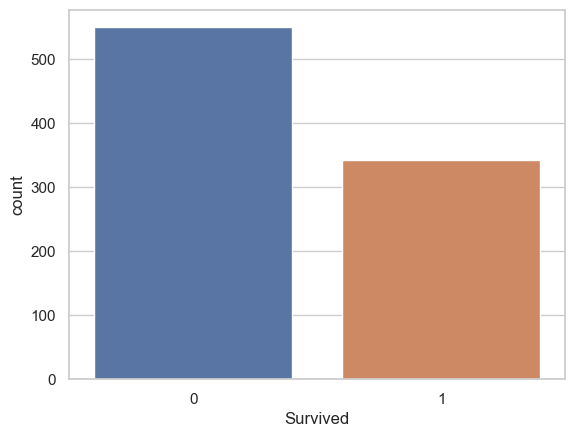

In [5]:
plot_feature(data_train, "Survived")

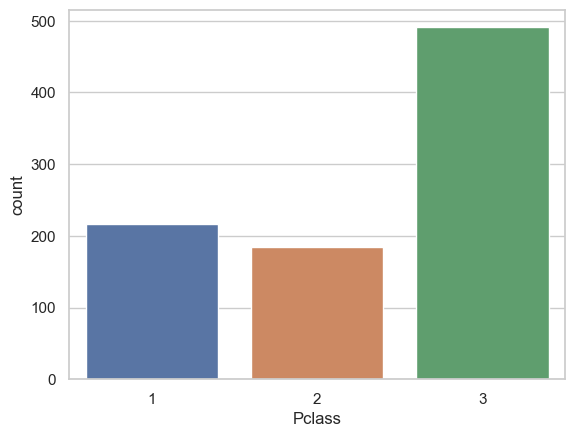

In [6]:
plot_feature(data_train, "Pclass")

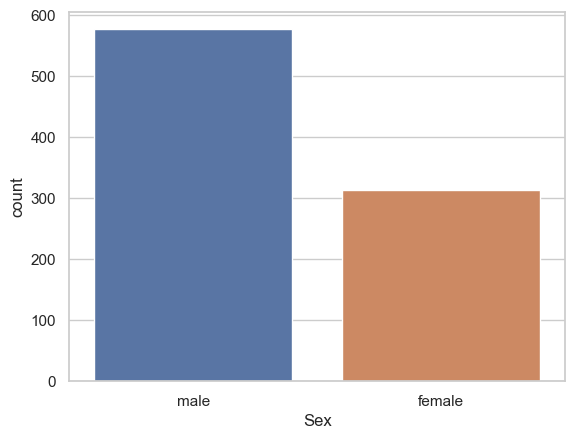

In [7]:
plot_feature(data_train, "Sex")

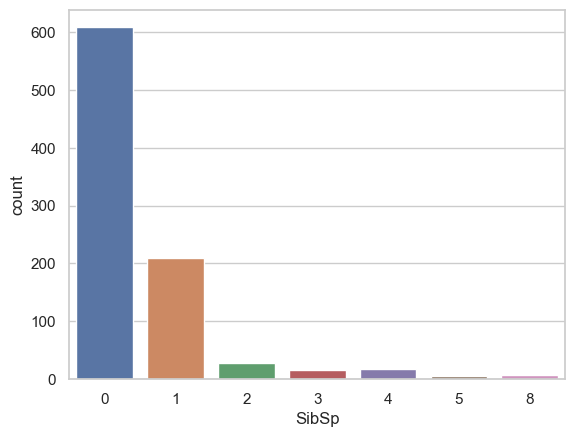

In [8]:
plot_feature(data_train, "SibSp")

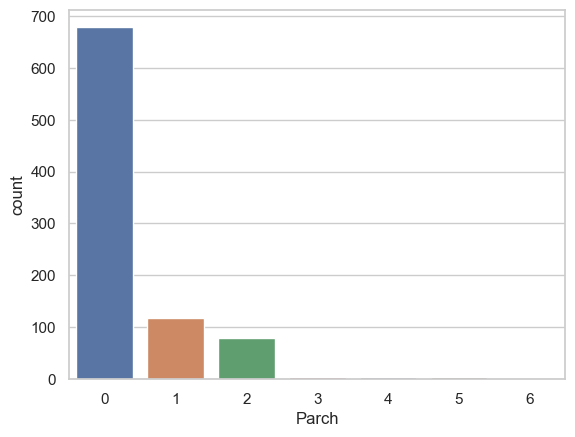

In [9]:
plot_feature(data_train, "Parch")

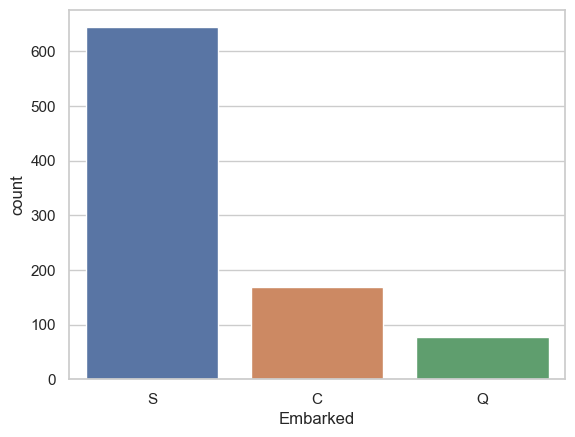

In [10]:
plot_feature(data_train, "Embarked")

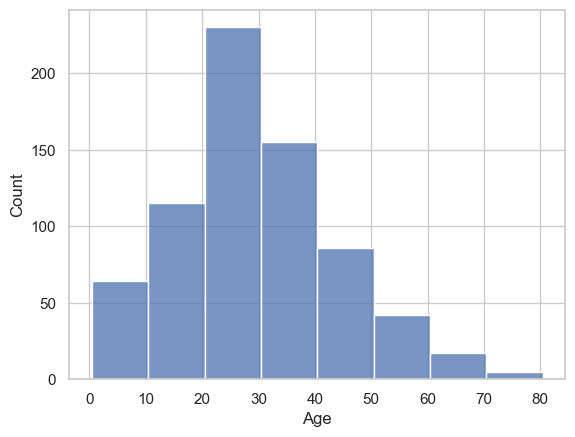

In [11]:
plot_feature_hist(data_train, "Age")

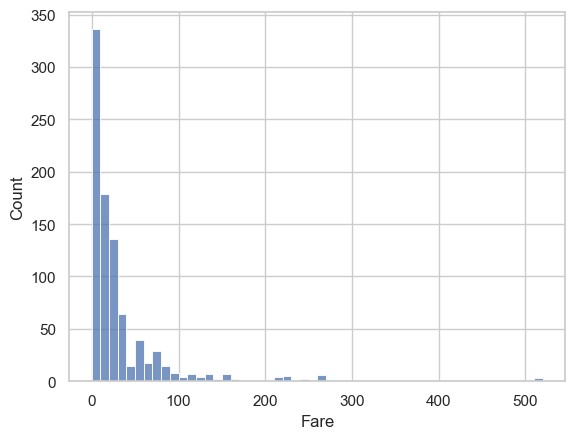

In [12]:
plot_feature_hist(data_train, "Fare")

What should raise our concern is certainly the unequal distribution in the **Survived** class, however, due to the very small data set, discarding part of the samples would significantly reduce our knowledge.

## 3. Data preparation

When we are familiar with our data, we can move on to preparing it. First, let's separate the **Survived** class from the rest of the features.

In [13]:
X_train = data_train.drop(["Survived"], axis=1)
y_train = data_train["Survived"]
X_test = data_test.drop(["Survived"], axis=1)
y_test = data_test["Survived"]

In [14]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

After analysis, we can conclude that features such as **PassengerId**, **Name**, **Ticket** are useless. We should also eliminate the **Cabin** feature, because in most cases this feature is empty. For further data preparation, we will divide the data into numeric and non-numeric.


In [16]:
num_attributes = ["Age", "SibSp", "Parch", "Fare"]
cat_attributes = ["Pclass", "Sex", "Embarked"]

X_train_num = X_train[num_attributes]
X_train_cat = X_train[cat_attributes]
X_test_num = X_test[num_attributes]
X_test_cat = X_test[cat_attributes]

In the next step we should fill the missing data in the numeric attributes. We will use median to fill in the empty fields. The most comfortable way is to implement pipeline

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
])

In [18]:
X_train_num = num_pipeline.fit_transform(X_train_num)
X_test_num = num_pipeline.transform(X_test_num)

After this we can fill empty fields in **Embarked** feature and proceed to convert the categorical data.


In [19]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse=False)),
])

In [20]:
X_train_cat = cat_pipeline.fit_transform(X_train_cat)
X_test_cat = cat_pipeline.transform(X_test_cat)

In [21]:
new_cat_attributes = []

for cat_set in cat_pipeline['cat_encoder'].categories_:
    for cat in cat_set:
        new_cat_attributes.append(cat)

In the next step we can merge ***X_train_cat*** and ***X_train_num*** together

In [22]:
attributes = num_attributes + new_cat_attributes
X_train_data = np.c_[X_train_num, X_train_cat]
X_test_data = np.c_[X_test_num, X_test_cat]

X_train = pd.DataFrame(X_train_data, columns=attributes)
X_test = pd.DataFrame(X_test_data, columns=attributes)

In [23]:
X_train.head()

,Age,SibSp,Parch,Fare,1,2,3,female,male,C,Q,S
0,22.0,1.0,0.0,7.2500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,38.0,1.0,0.0,71.2833,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,26.0,0.0,0.0,7.9250,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,35.0,1.0,0.0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,35.0,0.0,0.0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


Now, we should check the correlation of features (including class **Survived**)

In [24]:
X_train_surv = X_train.copy()
X_train_surv["Survived"] = y_train

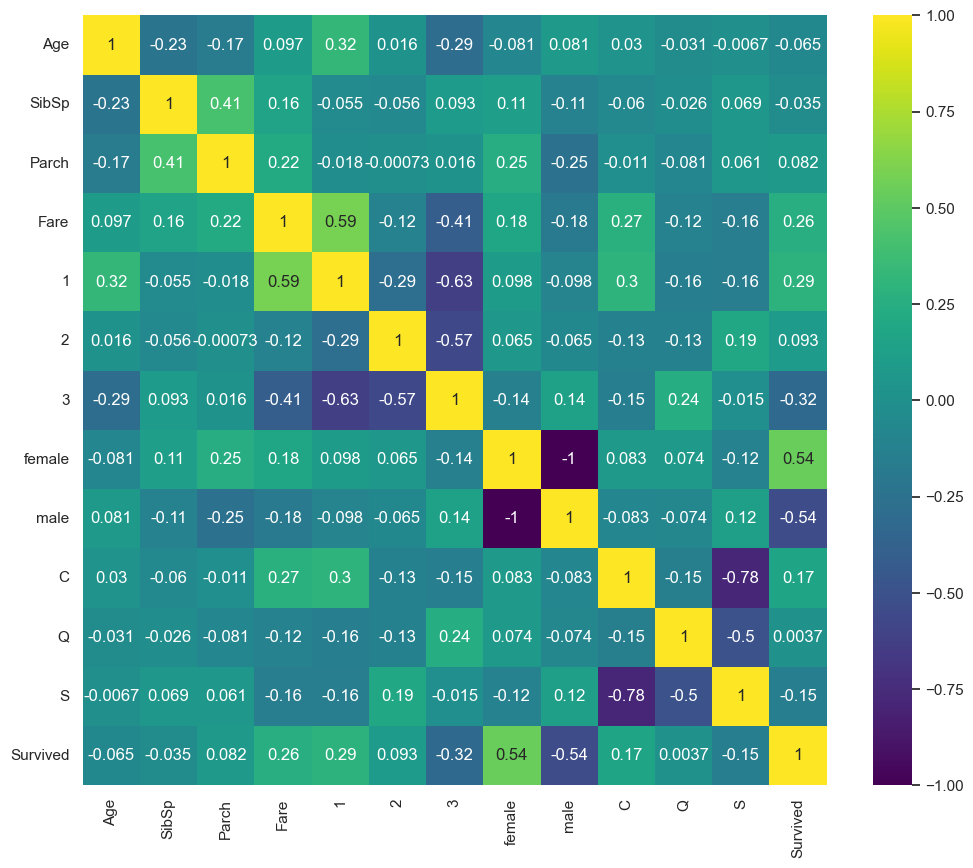

In [25]:
plot_correlation_matrix(X_train_surv)

In [26]:
X_train_surv.corr()["Survived"].sort_values(ascending=False)

Survived    1.000000
female      0.543351
1           0.285904
Fare        0.257307
C           0.168240
2           0.093349
Parch       0.081629
Q           0.003650
SibSp      -0.035322
Age        -0.064910
S          -0.149683
3          -0.322308
male       -0.543351
Name: Survived, dtype: float64

Unfortunately, we have few features strongly correlated with the **Survived** class, so the next step will be to add new features.

In [27]:
X_train["Family Members"] = X_train["Parch"] + X_train["SibSp"]
X_train["Not Alone"] = (X_train["Family Members"] != 0)

X_test["Family Members"] = X_test["Parch"] + X_test["SibSp"]
X_test["Not Alone"] = (X_test["Family Members"] != 0)

In [28]:
X_train_surv = X_train.copy()
X_train_surv["Survived"] = y_train

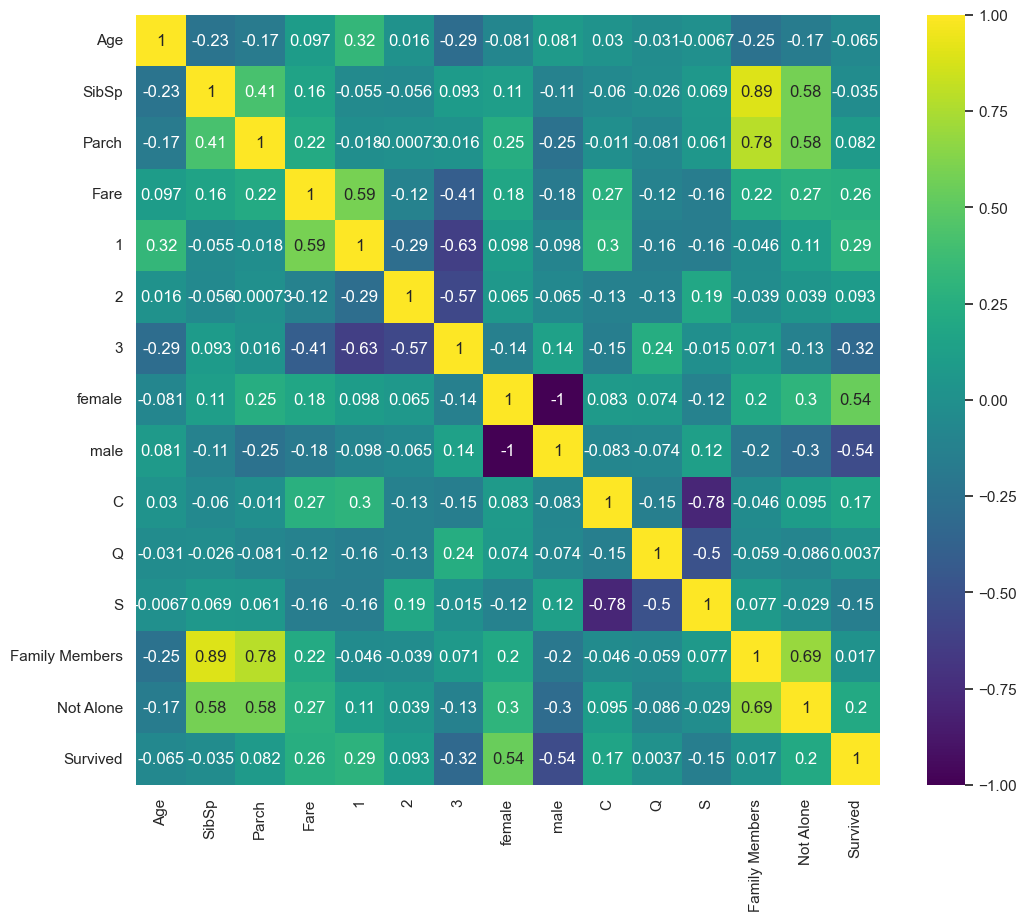

In [29]:
plot_correlation_matrix(X_train_surv)

In [30]:
X_train_surv.corr()["Survived"].sort_values(ascending=False)

Survived          1.000000
female            0.543351
1                 0.285904
Fare              0.257307
Not Alone         0.203367
C                 0.168240
2                 0.093349
Parch             0.081629
Family Members    0.016639
Q                 0.003650
SibSp            -0.035322
Age              -0.064910
S                -0.149683
3                -0.322308
male             -0.543351
Name: Survived, dtype: float64

In [31]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [32]:
X_train = X_train.drop(columns=['C', '2', 'Parch', 'Family Members', 'Q', 'SibSp', 'Age', 'S'])
X_test = X_test.drop(columns=['C', '2', 'Parch', 'Family Members', 'Q', 'SibSp', 'Age', 'S'])

In [33]:
X_train.head()

,Fare,1,3,female,male,Not Alone
0,7.2500,0.0,1.0,0.0,1.0,True
1,71.2833,1.0,0.0,1.0,0.0,True
2,7.9250,0.0,1.0,1.0,0.0,False
3,53.1000,1.0,0.0,1.0,0.0,True
4,8.0500,0.0,1.0,0.0,1.0,False


After removing insignificant features, we can move on to scaling the data.

In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

trans = StandardScaler()
X_train_t = trans.fit_transform(X_train)
X_test_t = trans.transform(X_test)

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train_t), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test_t), columns=X_train.columns)

In [35]:
X_train.head()

,Fare,1,3,female,male,Not Alone
0,0.014151,0.0,1.0,0.0,1.0,1.0
1,0.139136,1.0,0.0,1.0,0.0,1.0
2,0.015469,0.0,1.0,1.0,0.0,0.0
3,0.103644,1.0,0.0,1.0,0.0,1.0
4,0.015713,0.0,1.0,0.0,1.0,0.0


In [36]:
X_train.to_csv('./data/x_train_prep.csv', index=False)
X_test.to_csv('./data/x_test_prep.csv', index=False)
y_train.to_csv('./data/y_train_prep.csv', index=False)
y_test.to_csv('./data/y_test_prep.csv', index=False)

In [37]:
X_train_pd = X_train
X_train = X_train.to_numpy()

In [38]:
X_test_pd = X_test
X_test = X_test.to_numpy()

## 4. Model training

First, we'll start with base models with default parameters.

In [39]:
from sklearn.model_selection import cross_val_score, cross_val_predict

#### 4.1 Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42)

In [41]:
y_pred_log_reg = cross_val_predict(log_reg, X_train, y_train, cv=10)
log_reg_scores = cross_val_score(log_reg, X_train, y_train, cv=10)
log_reg_scores.mean()

0.7856179775280899

#### 4.2 SGD Classifier

In [42]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

In [43]:
y_pred_sgd_clf = cross_val_predict(sgd_clf, X_train, y_train, cv=10)
sgd_clf_scores = cross_val_score(sgd_clf, X_train, y_train, cv=10)
sgd_clf_scores.mean()

0.7788764044943821

#### 4.3 Random Forrest

In [44]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=7, random_state=42)

In [45]:
y_pred_forest_clf = cross_val_predict(forest_clf, X_train, y_train, cv=10)
forest_clf_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_clf_scores.mean()

0.812621722846442

## 5. Performance measures

#### 5.1 Confusion Matrix

<b>Logistic Regression</b>

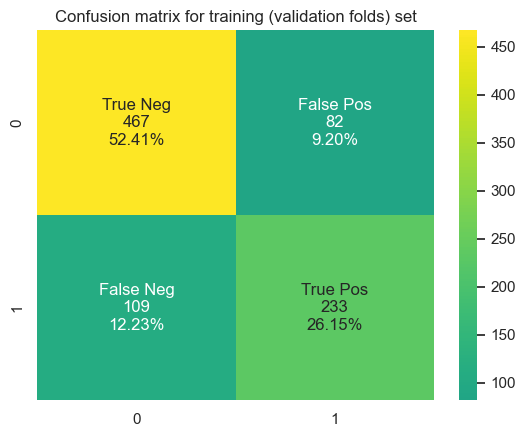

In [46]:
plot_confusion_matrix(y_train, y_pred_log_reg, set_type='training (validation folds)')

<b>SGD Classifier</b>

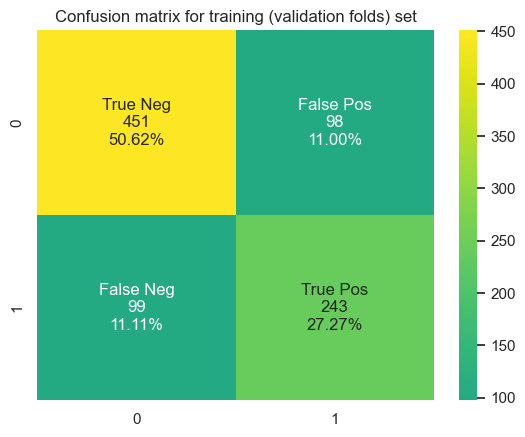

In [47]:
plot_confusion_matrix(y_train, y_pred_sgd_clf, set_type='training (validation folds)')

<b>Random Forest</b>

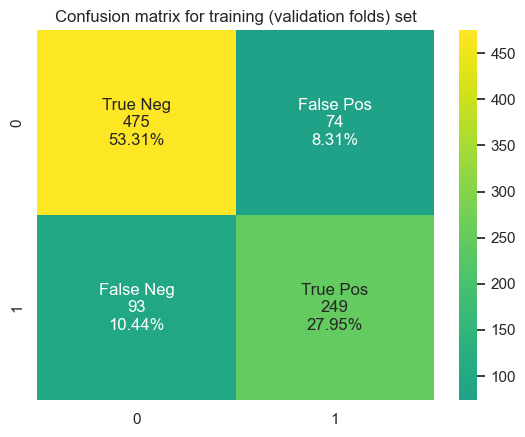

In [48]:
plot_confusion_matrix(y_train, y_pred_forest_clf, set_type='training (validation folds)')

#### 5.2 Accuracy, Precision, Recall, ${F_1}$score

<b>Logistic Regression</b>

In [49]:
metrics_log_reg = get_metrics(y_train, y_pred_log_reg)

Accuracy:  0.78563
Precision:  0.73968
Recall:  0.68129
F1 score:  0.70928


<b>SGD Classifier</b>

In [50]:
metrics_sgd_clf = get_metrics(y_train, y_pred_sgd_clf)

Accuracy:  0.7789
Precision:  0.71261
Recall:  0.71053
F1 score:  0.71157


<b>Random Forest</b>

In [51]:
metrics_forest_clf = get_metrics(y_train, y_pred_forest_clf)

Accuracy:  0.81257
Precision:  0.7709
Recall:  0.72807
F1 score:  0.74887


#### 5.3 Precision - recall curve

In [52]:
from sklearn.metrics import precision_recall_curve

<b>Logistic Regression</b>

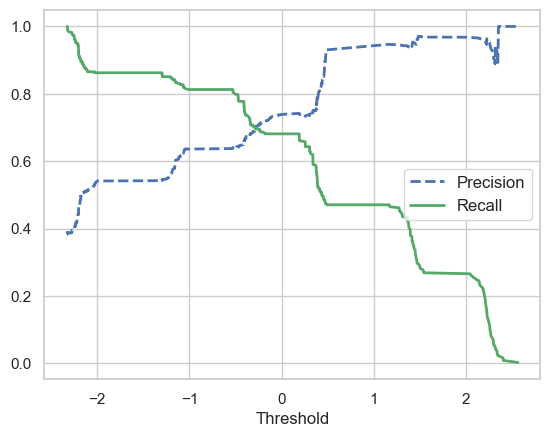

<Figure size 800x400 with 0 Axes>

In [53]:
y_scores_log_reg = cross_val_predict(log_reg, X_train, y_train, cv=10, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_log_reg)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

<b>SGD Classifier</b>

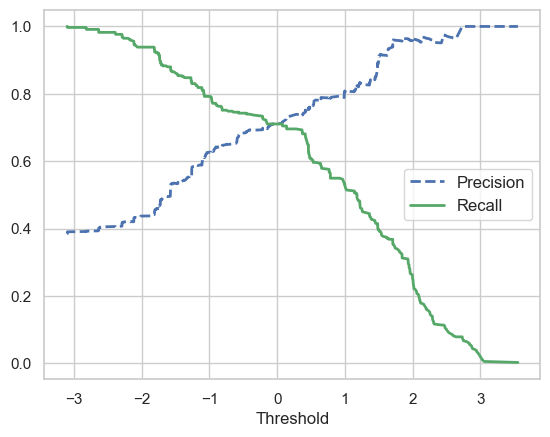

<Figure size 800x400 with 0 Axes>

In [54]:
y_scores_sgd_clf = cross_val_predict(sgd_clf, X_train, y_train, cv=10, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_sgd_clf)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

#### 5.4 ROC curve

In [55]:
from sklearn.metrics import roc_curve, roc_auc_score

<b>Logistic Regression</b>

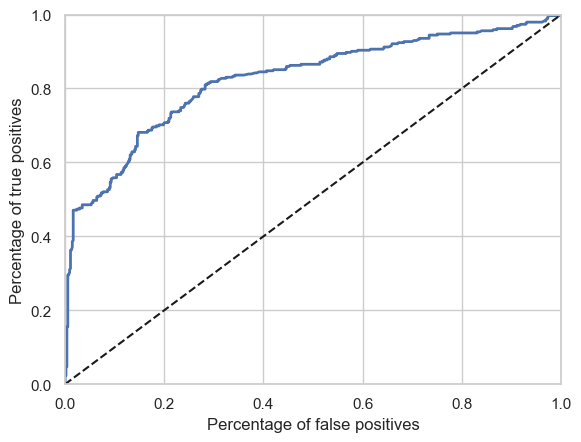

<Figure size 800x400 with 0 Axes>

ROC AUC score:  0.82472


In [56]:
fpr_log_reg, tpr_log_reg, thresholds = roc_curve(y_train, y_scores_log_reg)
plot_roc_curve(fpr_log_reg, tpr_log_reg)
print("ROC AUC score: ", round(roc_auc_score(y_train, y_scores_log_reg), 5))

<b>SGD Classifier</b>

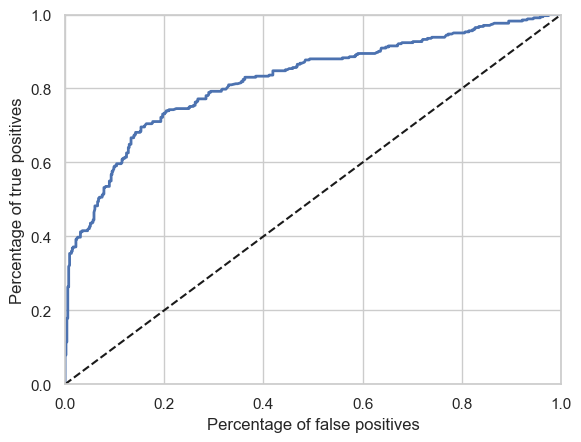

<Figure size 800x400 with 0 Axes>

ROC AUC score:  0.82234


In [57]:
fpr_sgd_clf, tpr_sgd_clf, thresholds = roc_curve(y_train, y_scores_sgd_clf)
plot_roc_curve(fpr_sgd_clf, tpr_sgd_clf)
print("ROC AUC score: ", round(roc_auc_score(y_train, y_scores_sgd_clf), 5))

<b>Random Forest</b>

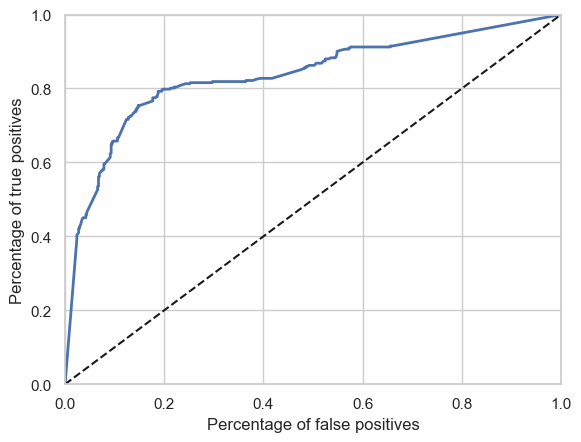

<Figure size 800x400 with 0 Axes>

ROC AUC score:  0.83583


In [58]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=10, method="predict_proba")
y_scores_forest_clf = y_probas_forest[:, 1]

fpr_forest_clf, tpr_forest_clf, thresholds = roc_curve(y_train, y_scores_forest_clf)
plot_roc_curve(fpr_forest_clf, tpr_forest_clf)
print("ROC AUC score: ", round(roc_auc_score(y_train, y_scores_forest_clf), 5))

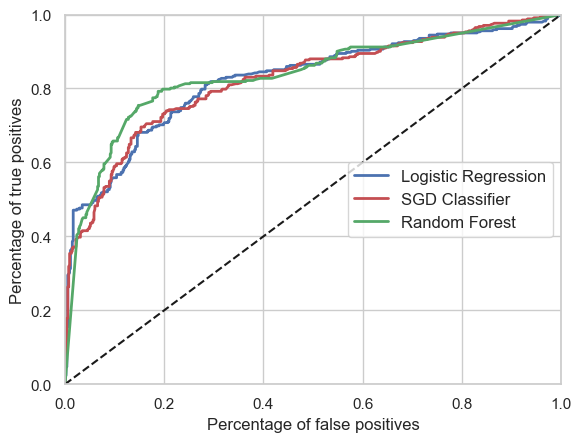

<Figure size 800x400 with 0 Axes>

In [59]:
plot_roc_curves(fpr_log_reg, tpr_log_reg, fpr_sgd_clf, tpr_sgd_clf, fpr_forest_clf, tpr_forest_clf, "Logistic Regression", "SGD Classifier", "Random Forest")

Comparing the three ROC curves, the one that has the largest area under the graph is the curve for the random forest. This is particularly evident on the left side of the graph, where the random forest clearly stands out from the other models.

## 6. Model improving

In [60]:
from sklearn.model_selection import GridSearchCV

#### 6.1 Logistic Regression

In [ ]:
param_grid_log_reg = [
    {"C":np.logspace(-3,3,14), "l1_ratio":np.logspace(-5, 0, 12)}
]

log_reg = LogisticRegression(solver='saga', penalty="elasticnet", max_iter=1e8)
log_reg_grid = GridSearchCV(log_reg, param_grid_log_reg, cv=10, scoring='accuracy')
log_reg_grid.fit(X_train, y_train)

In [62]:
cvres = log_reg_grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.616167290886392 {'C': 0.001, 'l1_ratio': 1e-05}
0.616167290886392 {'C': 0.001, 'l1_ratio': 2.848035868435799e-05}
0.616167290886392 {'C': 0.001, 'l1_ratio': 8.111308307896872e-05}
0.616167290886392 {'C': 0.001, 'l1_ratio': 0.0002310129700083158}
0.616167290886392 {'C': 0.001, 'l1_ratio': 0.0006579332246575682}
0.616167290886392 {'C': 0.001, 'l1_ratio': 0.001873817422860383}
0.616167290886392 {'C': 0.001, 'l1_ratio': 0.005336699231206307}
0.616167290886392 {'C': 0.001, 'l1_ratio': 0.01519911082952933}
0.616167290886392 {'C': 0.001, 'l1_ratio': 0.04328761281083057}
0.616167290886392 {'C': 0.001, 'l1_ratio': 0.12328467394420659}
0.616167290886392 {'C': 0.001, 'l1_ratio': 0.3511191734215127}
0.5925717852684145 {'C': 0.001, 'l1_ratio': 1.0}
0.6790387016229713 {'C': 0.0028942661247167516, 'l1_ratio': 1e-05}
0.6790387016229713 {'C': 0.0028942661247167516, 'l1_ratio': 2.848035868435799e-05}
0.6790387016229713 {'C': 0.0028942661247167516, 'l1_ratio': 8.111308307896872e-05}
0.6790387016229713 

In [63]:
log_reg_grid.best_params_

{'C': 0.008376776400682925, 'l1_ratio': 0.04328761281083057}

In [64]:
log_reg_grid.best_score_

0.7868039950062421

In [65]:
best_log_reg = log_reg_grid.best_estimator_

#### 6.2 SGD Classifier

In [ ]:
param_grid_sgd_clf = {
    'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], "l1_ratio":np.logspace(-5, 0, 12)
}

sgd = SGDClassifier(random_state=42, penalty="elasticnet")
sgd_clf_grid = GridSearchCV(sgd, param_grid_sgd_clf, cv=10, scoring='accuracy')
sgd_clf_grid.fit(X_train, y_train)

In [67]:
cvres = sgd_clf_grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.7788764044943821 {'alpha': 0.0001, 'l1_ratio': 1e-05}
0.7788764044943821 {'alpha': 0.0001, 'l1_ratio': 2.848035868435799e-05}
0.78 {'alpha': 0.0001, 'l1_ratio': 8.111308307896872e-05}
0.7743570536828963 {'alpha': 0.0001, 'l1_ratio': 0.0002310129700083158}
0.7844943820224719 {'alpha': 0.0001, 'l1_ratio': 0.0006579332246575682}
0.7755056179775281 {'alpha': 0.0001, 'l1_ratio': 0.001873817422860383}
0.7789513108614232 {'alpha': 0.0001, 'l1_ratio': 0.005336699231206307}
0.7799875156054932 {'alpha': 0.0001, 'l1_ratio': 0.01519911082952933}
0.7844694132334582 {'alpha': 0.0001, 'l1_ratio': 0.04328761281083057}
0.7867290886392011 {'alpha': 0.0001, 'l1_ratio': 0.12328467394420659}
0.7688264669163546 {'alpha': 0.0001, 'l1_ratio': 0.3511191734215127}
0.7833707865168539 {'alpha': 0.0001, 'l1_ratio': 1.0}
0.786729088639201 {'alpha': 0.0005, 'l1_ratio': 1e-05}
0.786729088639201 {'alpha': 0.0005, 'l1_ratio': 2.848035868435799e-05}
0.786729088639201 {'alpha': 0.0005, 'l1_ratio': 8.111308307896872e-05

In [68]:
sgd_clf_grid.best_params_

{'alpha': 0.0001, 'l1_ratio': 0.12328467394420659}

In [69]:
sgd_clf_grid.best_score_

0.7867290886392011

In [70]:
best_sgd_clf = sgd_clf_grid.best_estimator_

#### 6.3 Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid_forest_clf = [
    {"n_estimators": np.array(range(5, 20, 1)), "max_depth": [4, 5, 6, 7, 8], "max_features":[4, 5, 6, 7, 8], "min_samples_split":[3, 4, 5]}
]

forest_clf = RandomForestClassifier(random_state=42)
forest_clf_grid = GridSearchCV(forest_clf, param_grid_forest_clf, cv=10, scoring='accuracy')
forest_clf_grid.fit(X_train, y_train)

In [72]:
cvres = forest_clf_grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8036204744069912 {'max_depth': 4, 'max_features': 4, 'min_samples_split': 3, 'n_estimators': 5}
0.8069912609238452 {'max_depth': 4, 'max_features': 4, 'min_samples_split': 3, 'n_estimators': 6}
0.8047440699126092 {'max_depth': 4, 'max_features': 4, 'min_samples_split': 3, 'n_estimators': 7}
0.8069912609238452 {'max_depth': 4, 'max_features': 4, 'min_samples_split': 3, 'n_estimators': 8}
0.8081148564294631 {'max_depth': 4, 'max_features': 4, 'min_samples_split': 3, 'n_estimators': 9}
0.8013732833957553 {'max_depth': 4, 'max_features': 4, 'min_samples_split': 3, 'n_estimators': 10}
0.8036204744069911 {'max_depth': 4, 'max_features': 4, 'min_samples_split': 3, 'n_estimators': 11}
0.8058676654182271 {'max_depth': 4, 'max_features': 4, 'min_samples_split': 3, 'n_estimators': 12}
0.8036204744069912 {'max_depth': 4, 'max_features': 4, 'min_samples_split': 3, 'n_estimators': 13}
0.8047440699126092 {'max_depth': 4, 'max_features': 4, 'min_samples_split': 3, 'n_estimators': 14}
0.8024968789013

In [73]:
forest_clf_grid.best_params_

{'max_depth': 7, 'max_features': 4, 'min_samples_split': 5, 'n_estimators': 13}

In [74]:
forest_clf_grid.best_score_

0.8305867665418226

In [75]:
best_forest_clf = forest_clf_grid.best_estimator_

## 7. Prediction on the test set

#### 7.1 Logistic Regression

In [76]:
y_pred_log_reg = best_log_reg.predict(X_test)

In [77]:
metrics_best_log_reg = get_metrics(y_test, y_pred_log_reg)

Accuracy:  0.77033
Precision:  0.77679
Recall:  0.55063
F1 score:  0.64444


#### 7.2 SGD Classifier

In [78]:
y_pred_sgd_clf = best_sgd_clf.predict(X_test)

In [79]:
metrics_best_sgd_clf = get_metrics(y_test, y_pred_sgd_clf)

Accuracy:  0.76555
Precision:  0.69737
Recall:  0.67089
F1 score:  0.68387


#### 7.3 Random Forest

In [80]:
y_pred_forest_clf = best_forest_clf.predict(X_test)

In [81]:
metrics_best_forest_clf = get_metrics(y_test, y_pred_forest_clf)

Accuracy:  0.78469
Precision:  0.75
Recall:  0.64557
F1 score:  0.69388


As you can easily see, the random forest classifier achieves the best results. However, will the accuracy achieved also be better than that achieved by a neural network?

## 8. Neural Network Model

In [82]:
import tensorflow as tf

In [83]:
from sklearn.model_selection import train_test_split

X_train = X_train_pd
X_test = X_test_pd

X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [84]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=15,
                                            restore_best_weights=True)

In [85]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(X_train.shape[1], ),
        tf.keras.layers.Dense(units=10,
                              activation="relu",
                              kernel_initializer="he_normal",
                              name='L1'),
        tf.keras.layers.Dense(units=60,
                              activation="relu",
                              kernel_initializer="he_normal",
                              name='L2'),
        tf.keras.layers.Dense(units=60,
                              activation="relu",
                              kernel_initializer="he_normal",
                              name='L3'),
        tf.keras.layers.Dense(units=20,
                              activation="relu",
                              kernel_initializer="he_normal",
                              name='L4'),
        tf.keras.layers.Dense(units=1, activation='sigmoid', name='L5'),
    ], name='model'
)

In [86]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 10)                70        
                                                                 
 L2 (Dense)                  (None, 60)                660       
                                                                 
 L3 (Dense)                  (None, 60)                3660      
                                                                 
 L4 (Dense)                  (None, 20)                1220      
                                                                 
 L5 (Dense)                  (None, 1)                 21        
                                                                 
Total params: 5,631
Trainable params: 5,631
Non-trainable params: 0
_________________________________________________________________


In [87]:
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])

In [88]:
history = model.fit(X_train_nn, y_train_nn, epochs=100, validation_data=[X_val_nn, y_val_nn], batch_size=32, callbacks=[callback])

Epoch 1/100
23/23 [==============================] - 2s 19ms/step - loss: 0.7082 - accuracy: 0.5787 - val_loss: 0.6906 - val_accuracy: 0.5587
Epoch 2/100
23/23 [==============================] - 0s 8ms/step - loss: 0.6621 - accuracy: 0.5941 - val_loss: 0.6493 - val_accuracy: 0.5642
Epoch 3/100
23/23 [==============================] - 0s 9ms/step - loss: 0.6264 - accuracy: 0.6362 - val_loss: 0.6180 - val_accuracy: 0.7039
Epoch 4/100
23/23 [==============================] - 0s 8ms/step - loss: 0.6000 - accuracy: 0.7360 - val_loss: 0.5928 - val_accuracy: 0.7430
Epoch 5/100
23/23 [==============================] - 0s 8ms/step - loss: 0.5798 - accuracy: 0.7767 - val_loss: 0.5753 - val_accuracy: 0.7821
Epoch 6/100
23/23 [==============================] - 0s 8ms/step - loss: 0.5637 - accuracy: 0.7879 - val_loss: 0.5601 - val_accuracy: 0.7821
Epoch 7/100
23/23 [==============================] - 0s 9ms/step - loss: 0.5502 - accuracy: 0.7879 - val_loss: 0.5482 - val_accuracy: 0.7821
Epoch 8/100


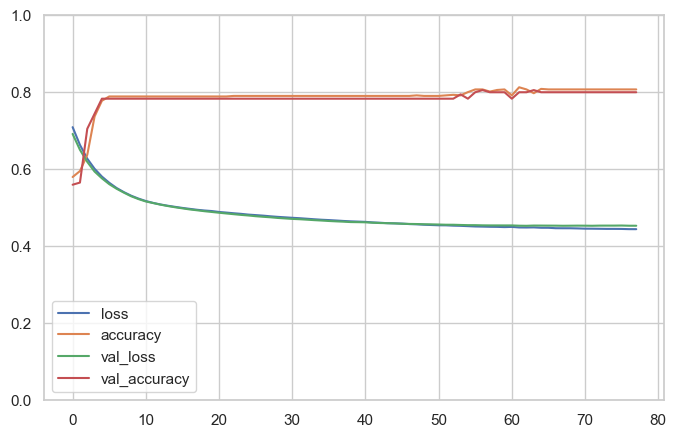

In [89]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [90]:
y_pred_probs_nn = model.predict(X_test)

14/14 [==============================] - 0s 2ms/step


In [91]:
y_pred_nn = np.round(y_pred_probs_nn)

In [92]:
metrics_nn = get_metrics(y_test, y_pred_nn)

Accuracy:  0.77033
Precision:  0.75833
Recall:  0.57595
F1 score:  0.65468


## Result

As you can see in the above experiments, for small datasets there is a chance that neural networks will not be able to get the best result of the expected metric. In our case, the random forest performed best. This fact confirms it's such a wide usage